# Minimal NeRF Demo — LEGO Scene

Implimentation adapted from [yenchenlin/nerf-pytorch](https://github.com/yenchenlin/nerf-pytorch)

In [ ]:

from pathlib import Path
import json
import math
import random

# Image and array helpers
import imageio.v2 as imageio
import numpy as np
# PyTorch core
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm


## 2. Positional Encoding and NeRF Network
NeRF follows the paper notation and lifts each 3D location $\mathbf{x}$ and viewing direction $\mathbf{d}$ into a richer signal with the positional encoding

$\gamma(\mathbf{u}) = (\mathbf{u}, \sin(2^{0}\mathbf{u}), \cos(2^{0}\mathbf{u}), \ldots, \sin(2^{L-1}\mathbf{u}), \cos(2^{L-1}\mathbf{u}))$

This encoding lets the network keep high frequency detail while still using a simple multilayer perceptron.

The network $F_{\Theta}$ produces a volume density $\sigma$ and emitted color $\mathbf{c}$:

$F_{\Theta}(\gamma(\mathbf{x}), \gamma(\mathbf{d})) = (\mathbf{c}, \sigma)$

PositionalEncoder.forward builds $\gamma(\mathbf{u})$ band by band. NeRF.forward applies the ReLU layers with one skip connection, then splits the output into $\sigma$ and a feature vector that mixes with the encoded view direction before the color head.

In [25]:
class PositionalEncoder(nn.Module):
    def __init__(self, num_frequencies: int, include_input: bool = True):
        super().__init__()
        # Store number of frequency bands
        self.num_frequencies = num_frequencies
        self.include_input = include_input
        self.output_dim = 0
        if include_input:
            # Count raw xyz channels
            self.output_dim += 3
        # Each band adds sine and cosine for xyz
        self.output_dim += 6 * num_frequencies

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        # Collect encoded bands
        encodings = []
        if self.include_input:
            # Keep raw xyz term
            encodings.append(inputs)
        for i in range(self.num_frequencies):
            freq = 2.0**i * math.pi
            # Add sine band
            encodings.append(torch.sin(freq * inputs))
            # Add cosine band
            encodings.append(torch.cos(freq * inputs))
        return torch.cat(encodings, dim=-1)


class NeRF(nn.Module):
    def __init__(self, depth: int = 8, width: int = 256, skips=(4,), num_freqs_xyz: int = 10, num_freqs_dir: int = 4):
        super().__init__()
        self.skips = skips
        self.encoder_xyz = PositionalEncoder(num_freqs_xyz)
        self.encoder_dir = PositionalEncoder(num_freqs_dir)

        in_ch_xyz = self.encoder_xyz.output_dim
        in_ch_dir = self.encoder_dir.output_dim

        layers = []
        for i in range(depth):
            if i == 0:
                # First layer reads encoded xyz
                layers.append(nn.Linear(in_ch_xyz, width))
            elif i in skips:
                # Skip layer joins activations with encoding
                layers.append(nn.Linear(width + in_ch_xyz, width))
            else:
                # Standard hidden layer
                layers.append(nn.Linear(width, width))
        self.layers = nn.ModuleList(layers)
        self.sigma_linear = nn.Linear(width, 1)
        self.feature_linear = nn.Linear(width, width)
        self.rgb_linear = nn.Linear(width + in_ch_dir, 3)

    def forward(self, x: torch.Tensor, d: torch.Tensor) -> torch.Tensor:
        # Encode xyz and view direction
        x_encoded = self.encoder_xyz(x)
        d_encoded = self.encoder_dir(d)

        h = x_encoded
        for i, layer in enumerate(self.layers):
            if i in self.skips:
                # Inject skip connection features
                h = torch.cat([h, x_encoded], dim=-1)
            h = layer(h)
            h = F.relu(h)

        sigma = F.relu(self.sigma_linear(h))
        feat = self.feature_linear(h)
        feat = F.relu(feat)
        h = torch.cat([feat, d_encoded], dim=-1)
        rgb = torch.sigmoid(self.rgb_linear(h))
        return torch.cat([rgb, sigma], dim=-1)


## 3. Dataset Loader
Each Blender frame stores a camera to world transform $T_{c\rightarrow w}$ and the horizontal field of view $\theta_x$. The focal length follows the paper with

$f = \frac{0.5\, W}{\tan(0.5\, \theta_x)}$

The loader reads the JSON metadata, keeps the rotation and translation inside $T_{c\rightarrow w}$, and collects every RGB image as float values in $[0,1]$. These tensors feed the ray sampler later on.

In [28]:

def load_lego_dataset(dataset_root: Path):
    # Gather splits used for training and validation
    splits = ["train", "val"]
    metas = {}
    for split in splits:
        meta_path = dataset_root / f"transforms_{split}.json"
        if not meta_path.exists():
            raise FileNotFoundError(f"Missing metadata file: {meta_path}")
        with meta_path.open("r") as f:
            metas[split] = json.load(f)

    first_frame_path = dataset_root / f"{metas['train']['frames'][0]['file_path']}.png"
    if not first_frame_path.exists():
        raise FileNotFoundError(f"Image file referenced in JSON not found: {first_frame_path}")
    sample_img = imageio.imread(first_frame_path)
    if sample_img.ndim == 2:
        raise ValueError("Expected RGB(A) image, received grayscale.")
    height, width = sample_img.shape[:2]
    camera_angle_x = metas["train"]["camera_angle_x"]
    focal = 0.5 * width / math.tan(0.5 * camera_angle_x)

    def _load_split(split: str):
        # Load images and poses for one split
        imgs = []
        poses = []
        for frame in metas[split]["frames"]:
            img_path = dataset_root / f"{frame['file_path']}.png"
            img = imageio.imread(img_path)
            img = img[..., :3]
            # Normalize pixel values to zero one
            imgs.append(img.astype(np.float32) / 255.0)
            poses.append(np.array(frame["transform_matrix"], dtype=np.float32))
        return np.stack(imgs), np.stack(poses)

    train_imgs, train_poses = _load_split("train")
    val_imgs, val_poses = _load_split("val")
    return train_imgs, train_poses, val_imgs, val_poses, height, width, focal


## 4. Camera Rays and Pixel Sampling
For each pixel $(i,j)$ the camera space ray direction is

$\mathbf{d}_{ij} = \left( \frac{j - W/2}{f},\; -\frac{i - H/2}{f},\; -1 \right)$

Multiplying by $T_{c\rightarrow w}$ gives the world origin $\mathbf{o}$ and direction $\mathbf{d}$ so the ray is $\mathbf{o} + t\mathbf{d}$. create_ray_directions builds the camera grid, get_rays moves it to world space, and sample_random_rays draws a small random set of rays together with their target colors for training.

In [29]:

def create_ray_directions(height: int, width: int, focal: float, device: torch.device) -> torch.Tensor:
    # Build grid of pixel coordinates
    i_coords, j_coords = torch.meshgrid(
        torch.arange(height, dtype=torch.float32, device=device),
        torch.arange(width, dtype=torch.float32, device=device),
        indexing="ij",
    )
    dirs = torch.stack(
        [
            (j_coords - width * 0.5) / focal,
            -(i_coords - height * 0.5) / focal,
            -torch.ones_like(i_coords),
        ],
        dim=-1,
    )
    return dirs


def get_rays(directions: torch.Tensor, c2w: torch.Tensor):
    # Rotate directions into world space and set origin
    rays_d = torch.matmul(directions, c2w[:3, :3].T)
    rays_o = c2w[:3, 3].expand(rays_d.shape)
    return rays_o, rays_d


def sample_random_rays(train_imgs: torch.Tensor, train_poses: torch.Tensor, directions: torch.Tensor, n_rays: int, device: torch.device):
    # Pick a random training image
    n_images, height, width, _ = train_imgs.shape
    img_idx = random.randint(0, n_images - 1)

    pose = train_poses[img_idx].to(device)
    rays_o, rays_d = get_rays(directions, pose)

    target = train_imgs[img_idx].to(device)
    coords_i = torch.randint(0, height, (n_rays,), device=device)
    coords_j = torch.randint(0, width, (n_rays,), device=device)

    # Gather the chosen rays and their colors
    rays_o = rays_o[coords_i, coords_j]
    rays_d = rays_d[coords_i, coords_j]
    pixel_rgb = target[coords_i, coords_j]
    return rays_o, rays_d, pixel_rgb


## 5. Volume Rendering
NeRF samples points $t_i$ along each ray between $t_{\text{near}}$ and $t_{\text{far}}$. Stratified sampling jitters the bins as in the paper. For each sample the renderer uses the weights

$w_i = T_i \left(1 - \exp(-\sigma_i \Delta_i)\right)$ with $T_i = \exp\left(-\sum_{j<i} \sigma_j \Delta_j\right)$

The expected color and depth are

$\hat{\mathbf{C}} = \sum_i w_i \mathbf{c}_i$, \quad $\hat{D} = \sum_i w_i t_i$

The helper volume_render_rays carries out these steps and render_image sweeps through every ray of a validation frame without perturbation. The full paper adds a second pass that draws extra points from the PDF $p(t_i) = w_i / \sum_j w_j$ using inverse transform sampling so high density regions receive more attention.

In [31]:

def volume_render_rays(model: NeRF, rays_o: torch.Tensor, rays_d: torch.Tensor, near: float, far: float, n_samples: int, perturb: bool):
    device = rays_o.device
    n_rays = rays_o.shape[0]
    # Sample depth values between near and far
    t_vals = torch.linspace(0.0, 1.0, steps=n_samples, device=device)
    z_vals = near * (1.0 - t_vals) + far * t_vals
    z_vals = z_vals.expand(n_rays, n_samples)

    if perturb:
        # Jitter bins for stratified sampling
        mids = 0.5 * (z_vals[:, 1:] + z_vals[:, :-1])
        upper = torch.cat([mids, z_vals[:, -1:]], dim=-1)
        lower = torch.cat([z_vals[:, :1], mids], dim=-1)
        t_rand = torch.rand(z_vals.shape, device=device)
        z_vals = lower + (upper - lower) * t_rand

    # Project sample points along each ray
    pts = rays_o[:, None, :] + rays_d[:, None, :] * z_vals[..., None]
    view_dirs = F.normalize(rays_d, dim=-1)
    view_dirs = view_dirs[:, None, :].expand_as(pts)

    # Flatten for batched network query
    pts_flat = pts.reshape(-1, 3)
    view_dirs_flat = view_dirs.reshape(-1, 3)

    raw = model(pts_flat, view_dirs_flat)
    raw = raw.reshape(n_rays, n_samples, 4)

    rgbs = raw[..., :3]
    sigmas = raw[..., 3]

    # Compute distances between samples
    deltas = z_vals[:, 1:] - z_vals[:, :-1]
    delta_inf = torch.tensor([1e10], device=device).expand_as(deltas[:, :1])
    deltas = torch.cat([deltas, delta_inf], dim=-1)

    # Turn densities into alpha values and weights
    alphas = 1.0 - torch.exp(-sigmas * deltas)
    transmittance = torch.cumprod(
        torch.cat([torch.ones((n_rays, 1), device=device), 1.0 - alphas + 1e-10], dim=-1),
        dim=-1,
    )
    weights = alphas * transmittance[:, :-1]

    # Reduce weighted color depth opacity
    rgb_map = torch.sum(weights[..., None] * rgbs, dim=-2)
    depth_map = torch.sum(weights * z_vals, dim=-1)
    acc_map = torch.sum(weights, dim=-1)
    return rgb_map, depth_map, acc_map


def render_image(model: NeRF, directions: torch.Tensor, pose: torch.Tensor, near: float, far: float, n_samples: int, chunk: int):
    H, W, _ = directions.shape
    rays_o, rays_d = get_rays(directions, pose)
    rays_o = rays_o.reshape(-1, 3)
    rays_d = rays_d.reshape(-1, 3)

    rgb_chunks = []
    with torch.no_grad():
        for i in range(0, rays_o.shape[0], chunk):
            ro = rays_o[i : i + chunk]
            rd = rays_d[i : i + chunk]
            # Render chunk without stratified jitter
            rgb, _, _ = volume_render_rays(model, ro, rd, near, far, n_samples, perturb=False)
            rgb_chunks.append(rgb)
    rgb_full = torch.cat(rgb_chunks, dim=0)
    # Reshape back to the image grid
    return rgb_full.reshape(H, W, 3)


def psnr_from_mse(mse: float) -> float:
    # Convert mean squared error to PSNR
    return -10.0 * math.log10(max(mse, 1e-10))


## 6. Experiment Configuration
This block wires the dataset, precomputes the ray directions, and creates the NeRF model. The training loss is the mean squared error between predicted and target RGB values, and the notebook tracks PSNR using $\mathrm{PSNR} = -10 \log_{10}(\mathrm{MSE})$.

In [32]:

data_root = Path("data/nerf_synthetic/lego")
output_dir = Path("outputs")
output_dir.mkdir(parents=True, exist_ok=True)

# Training hyperparameters
num_iters = 20000  # Try 2000 for quicker dry-runs
batch_rays = 1024
samples_per_ray = 64
near, far = 2.0, 6.0
learning_rate = 5e-4
render_every = 5000
validation_chunk = 4096

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset tensors and helper constants
train_imgs_np, train_poses_np, val_imgs_np, val_poses_np, H, W, focal = load_lego_dataset(data_root)
train_imgs = torch.from_numpy(train_imgs_np)
train_poses = torch.from_numpy(train_poses_np)
val_imgs = torch.from_numpy(val_imgs_np)
val_poses = torch.from_numpy(val_poses_np)

# Precompute camera directions and pick a validation view
directions = create_ray_directions(H, W, focal, device)
val_pose = val_poses[0].to(device)
val_img = val_imgs[0].to(device)

# Create model and optimizer
model = NeRF().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
log_entries = []


Using device: cpu


## 7. Training Loop
The objective follows the paper with

$\mathcal{L}(\Theta) = \frac{1}{N} \sum_{n=1}^{N} \lVert \hat{\mathbf{C}}_n - \mathbf{C}_n \rVert_2^2$

Each step samples a fresh mini batch of rays, renders them with volume_render_rays, and updates $\Theta$ using Adam. Every few steps the script renders a validation image to monitor PSNR and the qualitative result.

In [33]:

for step in tqdm(range(1, num_iters + 1), desc="Training", unit="iter"):
    model.train()
    # Sample a random batch of rays
    rays_o, rays_d, target_rgb = sample_random_rays(train_imgs, train_poses, directions, batch_rays, device)
    # Render predicted colors for the batch
    rgb, _, _ = volume_render_rays(model, rays_o, rays_d, near, far, samples_per_ray, perturb=True)

    # Compute loss and update model
    loss = F.mse_loss(rgb, target_rgb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 100 == 0:
        train_psnr = psnr_from_mse(loss.item())
        tqdm.write(f"[Iter {step}] Loss: {loss.item():.6f}  PSNR: {train_psnr:.2f}dB")

    if step % render_every == 0 or step == num_iters:
        model.eval()
        with torch.no_grad():
            # Render validation image for monitoring
            rgb_val = render_image(model, directions, val_pose, near, far, samples_per_ray, chunk=validation_chunk)
            val_loss = F.mse_loss(rgb_val, val_img).item()
            val_psnr = psnr_from_mse(val_loss)

        render_path = output_dir / f"render_step_{step:06d}.png"
        imageio.imwrite(render_path, np.clip(rgb_val.cpu().numpy() * 255.0, 0, 255).astype(np.uint8))
        torch.save(model.state_dict(), output_dir / "checkpoint_latest.pt")

        log_entry = {
            "iter": step,
            "train_loss": loss.item(),
            "train_psnr": psnr_from_mse(loss.item()),
            "val_loss": val_loss,
            "val_psnr": val_psnr,
        }
        log_entries.append(log_entry)
        with (output_dir / "metrics.json").open("w") as f:
            json.dump(log_entries, f, indent=2)

print("Training complete!")


Training:   0%|          | 100/20000 [00:25<1:26:32,  3.83iter/s]

[Iter 100] Loss: 0.067122  PSNR: 11.73dB


Training:   1%|          | 200/20000 [00:51<1:22:46,  3.99iter/s]

[Iter 200] Loss: 0.050585  PSNR: 12.96dB


Training:   2%|▏         | 300/20000 [01:17<1:20:43,  4.07iter/s]

[Iter 300] Loss: 0.046455  PSNR: 13.33dB


Training:   2%|▏         | 400/20000 [01:42<1:24:34,  3.86iter/s]

[Iter 400] Loss: 0.066898  PSNR: 11.75dB


Training:   2%|▎         | 500/20000 [02:08<1:26:29,  3.76iter/s]

[Iter 500] Loss: 0.098815  PSNR: 10.05dB


Training:   3%|▎         | 600/20000 [02:34<1:21:30,  3.97iter/s]

[Iter 600] Loss: 0.100369  PSNR: 9.98dB


Training:   4%|▎         | 700/20000 [02:59<1:19:55,  4.02iter/s]

[Iter 700] Loss: 0.072086  PSNR: 11.42dB


Training:   4%|▍         | 800/20000 [03:25<1:21:32,  3.92iter/s]

[Iter 800] Loss: 0.042235  PSNR: 13.74dB


Training:   4%|▍         | 900/20000 [03:50<1:22:04,  3.88iter/s]

[Iter 900] Loss: 0.131958  PSNR: 8.80dB


Training:   5%|▌         | 1000/20000 [04:16<1:20:26,  3.94iter/s]

[Iter 1000] Loss: 0.088888  PSNR: 10.51dB


Training:   6%|▌         | 1100/20000 [04:41<1:20:05,  3.93iter/s]

[Iter 1100] Loss: 0.117748  PSNR: 9.29dB


Training:   6%|▌         | 1200/20000 [05:06<1:18:35,  3.99iter/s]

[Iter 1200] Loss: 0.152373  PSNR: 8.17dB


Training:   6%|▋         | 1300/20000 [05:32<1:16:58,  4.05iter/s]

[Iter 1300] Loss: 0.139798  PSNR: 8.54dB


Training:   7%|▋         | 1400/20000 [05:57<1:19:58,  3.88iter/s]

[Iter 1400] Loss: 0.159171  PSNR: 7.98dB


Training:   8%|▊         | 1500/20000 [06:23<1:15:26,  4.09iter/s]

[Iter 1500] Loss: 0.130401  PSNR: 8.85dB


Training:   8%|▊         | 1600/20000 [06:48<1:20:49,  3.79iter/s]

[Iter 1600] Loss: 0.089270  PSNR: 10.49dB


Training:   8%|▊         | 1700/20000 [07:13<1:17:08,  3.95iter/s]

[Iter 1700] Loss: 0.030918  PSNR: 15.10dB


Training:   9%|▉         | 1800/20000 [07:38<1:15:41,  4.01iter/s]

[Iter 1800] Loss: 0.063166  PSNR: 12.00dB


Training:  10%|▉         | 1900/20000 [08:03<1:14:53,  4.03iter/s]

[Iter 1900] Loss: 0.031158  PSNR: 15.06dB


Training:  10%|█         | 2000/20000 [08:28<1:16:01,  3.95iter/s]

[Iter 2000] Loss: 0.079823  PSNR: 10.98dB


Training:  10%|█         | 2100/20000 [08:53<1:14:47,  3.99iter/s]

[Iter 2100] Loss: 0.150140  PSNR: 8.24dB


Training:  11%|█         | 2200/20000 [09:18<1:12:51,  4.07iter/s]

[Iter 2200] Loss: 0.087982  PSNR: 10.56dB


Training:  12%|█▏        | 2300/20000 [09:43<1:13:22,  4.02iter/s]

[Iter 2300] Loss: 0.057752  PSNR: 12.38dB


Training:  12%|█▏        | 2400/20000 [10:08<1:12:32,  4.04iter/s]

[Iter 2400] Loss: 0.096772  PSNR: 10.14dB


Training:  12%|█▎        | 2500/20000 [10:33<1:11:04,  4.10iter/s]

[Iter 2500] Loss: 0.091841  PSNR: 10.37dB


Training:  13%|█▎        | 2600/20000 [10:59<1:11:10,  4.07iter/s]

[Iter 2600] Loss: 0.084118  PSNR: 10.75dB


Training:  14%|█▎        | 2700/20000 [11:24<1:10:03,  4.12iter/s]

[Iter 2700] Loss: 0.076896  PSNR: 11.14dB


Training:  14%|█▍        | 2800/20000 [11:48<1:11:10,  4.03iter/s]

[Iter 2800] Loss: 0.096999  PSNR: 10.13dB


Training:  14%|█▍        | 2900/20000 [12:13<1:11:03,  4.01iter/s]

[Iter 2900] Loss: 0.104588  PSNR: 9.81dB


Training:  15%|█▌        | 3000/20000 [12:38<1:10:37,  4.01iter/s]

[Iter 3000] Loss: 0.047979  PSNR: 13.19dB


Training:  16%|█▌        | 3100/20000 [13:03<1:28:42,  3.18iter/s]

[Iter 3100] Loss: 0.075784  PSNR: 11.20dB


Training:  16%|█▌        | 3200/20000 [13:28<1:08:04,  4.11iter/s]

[Iter 3200] Loss: 0.065109  PSNR: 11.86dB


Training:  16%|█▋        | 3300/20000 [13:52<1:08:15,  4.08iter/s]

[Iter 3300] Loss: 0.034635  PSNR: 14.60dB


Training:  17%|█▋        | 3400/20000 [14:17<1:08:00,  4.07iter/s]

[Iter 3400] Loss: 0.063902  PSNR: 11.94dB


Training:  18%|█▊        | 3500/20000 [14:42<1:07:29,  4.07iter/s]

[Iter 3500] Loss: 0.154645  PSNR: 8.11dB


Training:  18%|█▊        | 3600/20000 [15:07<1:10:25,  3.88iter/s]

[Iter 3600] Loss: 0.098304  PSNR: 10.07dB


Training:  18%|█▊        | 3700/20000 [15:32<1:08:12,  3.98iter/s]

[Iter 3700] Loss: 0.060854  PSNR: 12.16dB


Training:  19%|█▉        | 3800/20000 [15:57<1:06:42,  4.05iter/s]

[Iter 3800] Loss: 0.073338  PSNR: 11.35dB


Training:  20%|█▉        | 3900/20000 [16:21<1:06:28,  4.04iter/s]

[Iter 3900] Loss: 0.042062  PSNR: 13.76dB


Training:  20%|██        | 4000/20000 [16:46<1:07:02,  3.98iter/s]

[Iter 4000] Loss: 0.068455  PSNR: 11.65dB


Training:  20%|██        | 4100/20000 [17:10<1:06:28,  3.99iter/s]

[Iter 4100] Loss: 0.029538  PSNR: 15.30dB


Training:  21%|██        | 4200/20000 [17:35<1:03:33,  4.14iter/s]

[Iter 4200] Loss: 0.115399  PSNR: 9.38dB


Training:  22%|██▏       | 4300/20000 [17:59<1:04:14,  4.07iter/s]

[Iter 4300] Loss: 0.156860  PSNR: 8.04dB


Training:  22%|██▏       | 4400/20000 [18:24<1:03:45,  4.08iter/s]

[Iter 4400] Loss: 0.057841  PSNR: 12.38dB


Training:  22%|██▎       | 4500/20000 [18:48<1:04:27,  4.01iter/s]

[Iter 4500] Loss: 0.038638  PSNR: 14.13dB


Training:  23%|██▎       | 4600/20000 [19:13<1:03:04,  4.07iter/s]

[Iter 4600] Loss: 0.136253  PSNR: 8.66dB


Training:  24%|██▎       | 4700/20000 [19:37<1:02:27,  4.08iter/s]

[Iter 4700] Loss: 0.087296  PSNR: 10.59dB


Training:  24%|██▍       | 4800/20000 [20:02<1:03:11,  4.01iter/s]

[Iter 4800] Loss: 0.154292  PSNR: 8.12dB


Training:  24%|██▍       | 4900/20000 [20:27<1:01:37,  4.08iter/s]

[Iter 4900] Loss: 0.094741  PSNR: 10.23dB


Training:  25%|██▍       | 4999/20000 [20:52<1:00:51,  4.11iter/s]

[Iter 5000] Loss: 0.118785  PSNR: 9.25dB


Training:  26%|██▌       | 5100/20000 [22:52<1:00:34,  4.10iter/s]  

[Iter 5100] Loss: 0.052088  PSNR: 12.83dB


Training:  26%|██▌       | 5200/20000 [23:16<59:25,  4.15iter/s]  

[Iter 5200] Loss: 0.072776  PSNR: 11.38dB


Training:  26%|██▋       | 5300/20000 [23:40<59:12,  4.14iter/s]  

[Iter 5300] Loss: 0.060528  PSNR: 12.18dB


Training:  27%|██▋       | 5400/20000 [24:05<59:04,  4.12iter/s]  

[Iter 5400] Loss: 0.026628  PSNR: 15.75dB


Training:  28%|██▊       | 5500/20000 [24:29<58:29,  4.13iter/s]  

[Iter 5500] Loss: 0.054550  PSNR: 12.63dB


Training:  28%|██▊       | 5600/20000 [24:53<59:34,  4.03iter/s]  

[Iter 5600] Loss: 0.065938  PSNR: 11.81dB


Training:  28%|██▊       | 5700/20000 [25:18<57:56,  4.11iter/s]  

[Iter 5700] Loss: 0.110473  PSNR: 9.57dB


Training:  29%|██▉       | 5800/20000 [25:42<56:23,  4.20iter/s]

[Iter 5800] Loss: 0.103951  PSNR: 9.83dB


Training:  30%|██▉       | 5900/20000 [26:06<56:17,  4.17iter/s]  

[Iter 5900] Loss: 0.067726  PSNR: 11.69dB


Training:  30%|███       | 6000/20000 [26:31<56:55,  4.10iter/s]

[Iter 6000] Loss: 0.097817  PSNR: 10.10dB


Training:  30%|███       | 6100/20000 [26:55<57:02,  4.06iter/s]

[Iter 6100] Loss: 0.101319  PSNR: 9.94dB


Training:  31%|███       | 6200/20000 [27:20<56:29,  4.07iter/s]

[Iter 6200] Loss: 0.031276  PSNR: 15.05dB


Training:  32%|███▏      | 6300/20000 [27:45<57:14,  3.99iter/s]

[Iter 6300] Loss: 0.035022  PSNR: 14.56dB


Training:  32%|███▏      | 6400/20000 [28:09<54:08,  4.19iter/s]

[Iter 6400] Loss: 0.130347  PSNR: 8.85dB


Training:  32%|███▎      | 6500/20000 [28:33<54:35,  4.12iter/s]

[Iter 6500] Loss: 0.119750  PSNR: 9.22dB


Training:  33%|███▎      | 6600/20000 [28:58<55:09,  4.05iter/s]

[Iter 6600] Loss: 0.029341  PSNR: 15.33dB


Training:  34%|███▎      | 6700/20000 [29:22<52:37,  4.21iter/s]

[Iter 6700] Loss: 0.109961  PSNR: 9.59dB


Training:  34%|███▍      | 6800/20000 [29:46<52:44,  4.17iter/s]

[Iter 6800] Loss: 0.028120  PSNR: 15.51dB


Training:  34%|███▍      | 6900/20000 [30:10<52:34,  4.15iter/s]

[Iter 6900] Loss: 0.136971  PSNR: 8.63dB


Training:  35%|███▌      | 7000/20000 [30:34<52:23,  4.14iter/s]

[Iter 7000] Loss: 0.076673  PSNR: 11.15dB


Training:  36%|███▌      | 7100/20000 [30:58<51:54,  4.14iter/s]

[Iter 7100] Loss: 0.088343  PSNR: 10.54dB


Training:  36%|███▌      | 7200/20000 [31:23<51:15,  4.16iter/s]

[Iter 7200] Loss: 0.031519  PSNR: 15.01dB


Training:  36%|███▋      | 7300/20000 [31:47<51:08,  4.14iter/s]

[Iter 7300] Loss: 0.091757  PSNR: 10.37dB


Training:  37%|███▋      | 7400/20000 [32:12<51:29,  4.08iter/s]

[Iter 7400] Loss: 0.039020  PSNR: 14.09dB


Training:  38%|███▊      | 7500/20000 [32:36<50:24,  4.13iter/s]

[Iter 7500] Loss: 0.089222  PSNR: 10.50dB


Training:  38%|███▊      | 7600/20000 [33:01<49:34,  4.17iter/s]

[Iter 7600] Loss: 0.094944  PSNR: 10.23dB


Training:  38%|███▊      | 7700/20000 [33:25<49:44,  4.12iter/s]

[Iter 7700] Loss: 0.103486  PSNR: 9.85dB


Training:  39%|███▉      | 7800/20000 [33:49<50:05,  4.06iter/s]

[Iter 7800] Loss: 0.133116  PSNR: 8.76dB


Training:  40%|███▉      | 7900/20000 [34:14<48:21,  4.17iter/s]

[Iter 7900] Loss: 0.093595  PSNR: 10.29dB


Training:  40%|████      | 8000/20000 [34:38<49:15,  4.06iter/s]

[Iter 8000] Loss: 0.094292  PSNR: 10.26dB


Training:  40%|████      | 8100/20000 [35:03<48:12,  4.11iter/s]

[Iter 8100] Loss: 0.099488  PSNR: 10.02dB


Training:  41%|████      | 8200/20000 [35:28<48:48,  4.03iter/s]

[Iter 8200] Loss: 0.126430  PSNR: 8.98dB


Training:  42%|████▏     | 8300/20000 [35:52<48:09,  4.05iter/s]

[Iter 8300] Loss: 0.097494  PSNR: 10.11dB


Training:  42%|████▏     | 8400/20000 [36:17<47:37,  4.06iter/s]

[Iter 8400] Loss: 0.063281  PSNR: 11.99dB


Training:  42%|████▎     | 8500/20000 [36:42<47:26,  4.04iter/s]

[Iter 8500] Loss: 0.071573  PSNR: 11.45dB


Training:  43%|████▎     | 8600/20000 [37:06<46:04,  4.12iter/s]

[Iter 8600] Loss: 0.056857  PSNR: 12.45dB


Training:  44%|████▎     | 8700/20000 [37:32<46:43,  4.03iter/s]

[Iter 8700] Loss: 0.103310  PSNR: 9.86dB


Training:  44%|████▍     | 8800/20000 [37:56<46:42,  4.00iter/s]

[Iter 8800] Loss: 0.028508  PSNR: 15.45dB


Training:  44%|████▍     | 8900/20000 [38:21<45:27,  4.07iter/s]

[Iter 8900] Loss: 0.098395  PSNR: 10.07dB


Training:  45%|████▌     | 9000/20000 [38:46<44:10,  4.15iter/s]

[Iter 9000] Loss: 0.081922  PSNR: 10.87dB


Training:  46%|████▌     | 9100/20000 [39:10<44:34,  4.08iter/s]

[Iter 9100] Loss: 0.068823  PSNR: 11.62dB


Training:  46%|████▌     | 9200/20000 [39:34<43:30,  4.14iter/s]

[Iter 9200] Loss: 0.115471  PSNR: 9.38dB


Training:  46%|████▋     | 9300/20000 [39:59<45:15,  3.94iter/s]

[Iter 9300] Loss: 0.093755  PSNR: 10.28dB


Training:  47%|████▋     | 9400/20000 [40:24<42:42,  4.14iter/s]

[Iter 9400] Loss: 0.159917  PSNR: 7.96dB


Training:  48%|████▊     | 9500/20000 [40:49<44:15,  3.95iter/s]

[Iter 9500] Loss: 0.100431  PSNR: 9.98dB


Training:  48%|████▊     | 9600/20000 [41:14<43:49,  3.96iter/s]

[Iter 9600] Loss: 0.072389  PSNR: 11.40dB


Training:  48%|████▊     | 9700/20000 [41:40<43:17,  3.97iter/s]

[Iter 9700] Loss: 0.092324  PSNR: 10.35dB


Training:  49%|████▉     | 9800/20000 [42:05<41:40,  4.08iter/s]

[Iter 9800] Loss: 0.066692  PSNR: 11.76dB


Training:  50%|████▉     | 9900/20000 [42:29<41:58,  4.01iter/s]

[Iter 9900] Loss: 0.038865  PSNR: 14.10dB


Training:  50%|████▉     | 9999/20000 [42:55<41:47,  3.99iter/s]

[Iter 10000] Loss: 0.116369  PSNR: 9.34dB


Training:  50%|█████     | 10100/20000 [44:55<42:01,  3.93iter/s]   

[Iter 10100] Loss: 0.030336  PSNR: 15.18dB


Training:  51%|█████     | 10200/20000 [45:19<39:11,  4.17iter/s]

[Iter 10200] Loss: 0.083800  PSNR: 10.77dB


Training:  52%|█████▏    | 10300/20000 [45:43<38:19,  4.22iter/s]

[Iter 10300] Loss: 0.020641  PSNR: 16.85dB


Training:  52%|█████▏    | 10400/20000 [46:07<38:11,  4.19iter/s]

[Iter 10400] Loss: 0.155391  PSNR: 8.09dB


Training:  52%|█████▎    | 10500/20000 [46:31<37:59,  4.17iter/s]

[Iter 10500] Loss: 0.070553  PSNR: 11.51dB


Training:  53%|█████▎    | 10600/20000 [46:55<40:20,  3.88iter/s]

[Iter 10600] Loss: 0.109627  PSNR: 9.60dB


Training:  54%|█████▎    | 10700/20000 [47:21<38:43,  4.00iter/s]

[Iter 10700] Loss: 0.078882  PSNR: 11.03dB


Training:  54%|█████▍    | 10800/20000 [47:45<37:04,  4.14iter/s]

[Iter 10800] Loss: 0.075742  PSNR: 11.21dB


Training:  55%|█████▍    | 10900/20000 [48:09<36:53,  4.11iter/s]

[Iter 10900] Loss: 0.075911  PSNR: 11.20dB


Training:  55%|█████▌    | 11000/20000 [48:34<36:42,  4.09iter/s]

[Iter 11000] Loss: 0.131888  PSNR: 8.80dB


Training:  56%|█████▌    | 11100/20000 [48:59<37:40,  3.94iter/s]

[Iter 11100] Loss: 0.110513  PSNR: 9.57dB


Training:  56%|█████▌    | 11200/20000 [49:26<38:09,  3.84iter/s]

[Iter 11200] Loss: 0.069627  PSNR: 11.57dB


Training:  56%|█████▋    | 11300/20000 [49:50<36:37,  3.96iter/s]

[Iter 11300] Loss: 0.115657  PSNR: 9.37dB


Training:  57%|█████▋    | 11400/20000 [50:15<35:09,  4.08iter/s]

[Iter 11400] Loss: 0.059803  PSNR: 12.23dB


Training:  57%|█████▊    | 11500/20000 [50:41<34:55,  4.06iter/s]

[Iter 11500] Loss: 0.062964  PSNR: 12.01dB


Training:  58%|█████▊    | 11600/20000 [51:06<35:34,  3.93iter/s]

[Iter 11600] Loss: 0.050561  PSNR: 12.96dB


Training:  58%|█████▊    | 11700/20000 [51:31<35:23,  3.91iter/s]

[Iter 11700] Loss: 0.083498  PSNR: 10.78dB


Training:  59%|█████▉    | 11800/20000 [51:56<34:24,  3.97iter/s]

[Iter 11800] Loss: 0.153530  PSNR: 8.14dB


Training:  60%|█████▉    | 11900/20000 [52:22<34:14,  3.94iter/s]

[Iter 11900] Loss: 0.100146  PSNR: 9.99dB


Training:  60%|██████    | 12000/20000 [52:47<34:46,  3.83iter/s]

[Iter 12000] Loss: 0.044787  PSNR: 13.49dB


Training:  60%|██████    | 12100/20000 [53:12<32:15,  4.08iter/s]

[Iter 12100] Loss: 0.150984  PSNR: 8.21dB


Training:  61%|██████    | 12200/20000 [53:37<32:07,  4.05iter/s]

[Iter 12200] Loss: 0.031896  PSNR: 14.96dB


Training:  62%|██████▏   | 12300/20000 [54:02<32:05,  4.00iter/s]

[Iter 12300] Loss: 0.069159  PSNR: 11.60dB


Training:  62%|██████▏   | 12400/20000 [54:27<31:31,  4.02iter/s]

[Iter 12400] Loss: 0.072170  PSNR: 11.42dB


Training:  62%|██████▎   | 12500/20000 [54:52<31:03,  4.02iter/s]

[Iter 12500] Loss: 0.078335  PSNR: 11.06dB


Training:  63%|██████▎   | 12600/20000 [55:17<32:28,  3.80iter/s]

[Iter 12600] Loss: 0.165404  PSNR: 7.81dB


Training:  64%|██████▎   | 12700/20000 [55:43<30:17,  4.02iter/s]

[Iter 12700] Loss: 0.052451  PSNR: 12.80dB


Training:  64%|██████▍   | 12800/20000 [56:08<30:36,  3.92iter/s]

[Iter 12800] Loss: 0.077530  PSNR: 11.11dB


Training:  64%|██████▍   | 12900/20000 [56:34<29:23,  4.03iter/s]

[Iter 12900] Loss: 0.070782  PSNR: 11.50dB


Training:  65%|██████▌   | 13000/20000 [56:59<29:57,  3.89iter/s]

[Iter 13000] Loss: 0.090533  PSNR: 10.43dB


Training:  66%|██████▌   | 13100/20000 [57:25<28:27,  4.04iter/s]

[Iter 13100] Loss: 0.099752  PSNR: 10.01dB


Training:  66%|██████▌   | 13200/20000 [57:50<29:31,  3.84iter/s]

[Iter 13200] Loss: 0.068262  PSNR: 11.66dB


Training:  66%|██████▋   | 13300/20000 [58:15<27:39,  4.04iter/s]

[Iter 13300] Loss: 0.155753  PSNR: 8.08dB


Training:  67%|██████▋   | 13400/20000 [58:40<27:52,  3.95iter/s]

[Iter 13400] Loss: 0.110197  PSNR: 9.58dB


Training:  68%|██████▊   | 13500/20000 [59:05<28:05,  3.86iter/s]

[Iter 13500] Loss: 0.056582  PSNR: 12.47dB


Training:  68%|██████▊   | 13600/20000 [59:31<26:44,  3.99iter/s]

[Iter 13600] Loss: 0.045181  PSNR: 13.45dB


Training:  68%|██████▊   | 13700/20000 [59:56<28:38,  3.67iter/s]

[Iter 13700] Loss: 0.088204  PSNR: 10.55dB


Training:  69%|██████▉   | 13800/20000 [1:00:22<25:32,  4.05iter/s]

[Iter 13800] Loss: 0.035199  PSNR: 14.53dB


Training:  70%|██████▉   | 13900/20000 [1:00:47<26:21,  3.86iter/s]

[Iter 13900] Loss: 0.146377  PSNR: 8.35dB


Training:  70%|███████   | 14000/20000 [1:01:12<24:52,  4.02iter/s]

[Iter 14000] Loss: 0.144663  PSNR: 8.40dB


Training:  70%|███████   | 14100/20000 [1:01:38<25:21,  3.88iter/s]

[Iter 14100] Loss: 0.079994  PSNR: 10.97dB


Training:  71%|███████   | 14200/20000 [1:02:03<24:07,  4.01iter/s]

[Iter 14200] Loss: 0.153155  PSNR: 8.15dB


Training:  72%|███████▏  | 14300/20000 [1:02:28<25:09,  3.78iter/s]

[Iter 14300] Loss: 0.040137  PSNR: 13.96dB


Training:  72%|███████▏  | 14400/20000 [1:02:54<24:24,  3.82iter/s]

[Iter 14400] Loss: 0.089644  PSNR: 10.47dB


Training:  72%|███████▎  | 14500/20000 [1:03:19<22:54,  4.00iter/s]

[Iter 14500] Loss: 0.028426  PSNR: 15.46dB


Training:  73%|███████▎  | 14600/20000 [1:03:45<22:19,  4.03iter/s]

[Iter 14600] Loss: 0.124298  PSNR: 9.06dB


Training:  74%|███████▎  | 14700/20000 [1:04:10<22:19,  3.96iter/s]

[Iter 14700] Loss: 0.084586  PSNR: 10.73dB


Training:  74%|███████▍  | 14800/20000 [1:04:35<21:33,  4.02iter/s]

[Iter 14800] Loss: 0.110994  PSNR: 9.55dB


Training:  74%|███████▍  | 14900/20000 [1:05:00<20:57,  4.06iter/s]

[Iter 14900] Loss: 0.024438  PSNR: 16.12dB


Training:  75%|███████▍  | 14999/20000 [1:05:25<20:49,  4.00iter/s]

[Iter 15000] Loss: 0.147139  PSNR: 8.32dB


Training:  76%|███████▌  | 15100/20000 [1:07:24<19:50,  4.11iter/s]   

[Iter 15100] Loss: 0.034908  PSNR: 14.57dB


Training:  76%|███████▌  | 15200/20000 [1:07:49<19:08,  4.18iter/s]

[Iter 15200] Loss: 0.114488  PSNR: 9.41dB


Training:  76%|███████▋  | 15300/20000 [1:08:14<21:34,  3.63iter/s]

[Iter 15300] Loss: 0.153871  PSNR: 8.13dB


Training:  77%|███████▋  | 15400/20000 [1:08:39<19:13,  3.99iter/s]

[Iter 15400] Loss: 0.097258  PSNR: 10.12dB


Training:  78%|███████▊  | 15500/20000 [1:09:04<18:15,  4.11iter/s]

[Iter 15500] Loss: 0.157849  PSNR: 8.02dB


Training:  78%|███████▊  | 15600/20000 [1:09:28<17:59,  4.08iter/s]

[Iter 15600] Loss: 0.108724  PSNR: 9.64dB


Training:  78%|███████▊  | 15700/20000 [1:09:53<17:25,  4.11iter/s]

[Iter 15700] Loss: 0.031350  PSNR: 15.04dB


Training:  79%|███████▉  | 15800/20000 [1:10:19<17:21,  4.03iter/s]

[Iter 15800] Loss: 0.044425  PSNR: 13.52dB


Training:  80%|███████▉  | 15900/20000 [1:10:43<17:08,  3.99iter/s]

[Iter 15900] Loss: 0.092309  PSNR: 10.35dB


Training:  80%|████████  | 16000/20000 [1:11:08<16:25,  4.06iter/s]

[Iter 16000] Loss: 0.090975  PSNR: 10.41dB


Training:  80%|████████  | 16100/20000 [1:11:34<16:06,  4.03iter/s]

[Iter 16100] Loss: 0.104330  PSNR: 9.82dB


Training:  81%|████████  | 16200/20000 [1:11:59<15:25,  4.10iter/s]

[Iter 16200] Loss: 0.135032  PSNR: 8.70dB


Training:  82%|████████▏ | 16300/20000 [1:12:23<15:07,  4.08iter/s]

[Iter 16300] Loss: 0.069809  PSNR: 11.56dB


Training:  82%|████████▏ | 16400/20000 [1:12:48<14:44,  4.07iter/s]

[Iter 16400] Loss: 0.136551  PSNR: 8.65dB


Training:  82%|████████▎ | 16500/20000 [1:13:14<14:40,  3.98iter/s]

[Iter 16500] Loss: 0.037320  PSNR: 14.28dB


Training:  83%|████████▎ | 16600/20000 [1:13:39<14:12,  3.99iter/s]

[Iter 16600] Loss: 0.092859  PSNR: 10.32dB


Training:  84%|████████▎ | 16700/20000 [1:14:04<14:03,  3.91iter/s]

[Iter 16700] Loss: 0.096905  PSNR: 10.14dB


Training:  84%|████████▍ | 16800/20000 [1:14:30<13:12,  4.04iter/s]

[Iter 16800] Loss: 0.048157  PSNR: 13.17dB


Training:  84%|████████▍ | 16900/20000 [1:14:55<12:45,  4.05iter/s]

[Iter 16900] Loss: 0.030859  PSNR: 15.11dB


Training:  85%|████████▌ | 17000/20000 [1:15:21<12:40,  3.95iter/s]

[Iter 17000] Loss: 0.064113  PSNR: 11.93dB


Training:  86%|████████▌ | 17100/20000 [1:15:46<12:29,  3.87iter/s]

[Iter 17100] Loss: 0.052192  PSNR: 12.82dB


Training:  86%|████████▌ | 17200/20000 [1:16:12<11:39,  4.00iter/s]

[Iter 17200] Loss: 0.106530  PSNR: 9.73dB


Training:  86%|████████▋ | 17300/20000 [1:16:37<11:12,  4.01iter/s]

[Iter 17300] Loss: 0.071358  PSNR: 11.47dB


Training:  87%|████████▋ | 17400/20000 [1:17:03<11:08,  3.89iter/s]

[Iter 17400] Loss: 0.114206  PSNR: 9.42dB


Training:  88%|████████▊ | 17500/20000 [1:17:28<10:12,  4.08iter/s]

[Iter 17500] Loss: 0.041423  PSNR: 13.83dB


Training:  88%|████████▊ | 17600/20000 [1:17:53<10:15,  3.90iter/s]

[Iter 17600] Loss: 0.105598  PSNR: 9.76dB


Training:  88%|████████▊ | 17700/20000 [1:18:18<09:28,  4.05iter/s]

[Iter 17700] Loss: 0.098810  PSNR: 10.05dB


Training:  89%|████████▉ | 17800/20000 [1:18:43<09:11,  3.99iter/s]

[Iter 17800] Loss: 0.100781  PSNR: 9.97dB


Training:  90%|████████▉ | 17900/20000 [1:19:08<08:46,  3.99iter/s]

[Iter 17900] Loss: 0.114787  PSNR: 9.40dB


Training:  90%|█████████ | 18000/20000 [1:19:34<08:14,  4.05iter/s]

[Iter 18000] Loss: 0.121341  PSNR: 9.16dB


Training:  90%|█████████ | 18100/20000 [1:19:59<07:55,  3.99iter/s]

[Iter 18100] Loss: 0.115955  PSNR: 9.36dB


Training:  91%|█████████ | 18200/20000 [1:20:24<07:30,  3.99iter/s]

[Iter 18200] Loss: 0.130590  PSNR: 8.84dB


Training:  92%|█████████▏| 18300/20000 [1:20:50<07:07,  3.98iter/s]

[Iter 18300] Loss: 0.148005  PSNR: 8.30dB


Training:  92%|█████████▏| 18400/20000 [1:21:15<06:39,  4.01iter/s]

[Iter 18400] Loss: 0.074226  PSNR: 11.29dB


Training:  92%|█████████▎| 18500/20000 [1:21:40<06:12,  4.02iter/s]

[Iter 18500] Loss: 0.133949  PSNR: 8.73dB


Training:  93%|█████████▎| 18600/20000 [1:22:05<05:53,  3.96iter/s]

[Iter 18600] Loss: 0.070228  PSNR: 11.53dB


Training:  94%|█████████▎| 18700/20000 [1:22:32<06:09,  3.52iter/s]

[Iter 18700] Loss: 0.045327  PSNR: 13.44dB


Training:  94%|█████████▍| 18800/20000 [1:22:57<05:01,  3.98iter/s]

[Iter 18800] Loss: 0.072261  PSNR: 11.41dB


Training:  94%|█████████▍| 18900/20000 [1:23:23<04:40,  3.92iter/s]

[Iter 18900] Loss: 0.073153  PSNR: 11.36dB


Training:  95%|█████████▌| 19000/20000 [1:23:49<04:09,  4.02iter/s]

[Iter 19000] Loss: 0.088664  PSNR: 10.52dB


Training:  96%|█████████▌| 19100/20000 [1:24:14<03:42,  4.05iter/s]

[Iter 19100] Loss: 0.120580  PSNR: 9.19dB


Training:  96%|█████████▌| 19200/20000 [1:24:39<03:21,  3.97iter/s]

[Iter 19200] Loss: 0.082320  PSNR: 10.84dB


Training:  96%|█████████▋| 19300/20000 [1:25:05<02:57,  3.94iter/s]

[Iter 19300] Loss: 0.150271  PSNR: 8.23dB


Training:  97%|█████████▋| 19400/20000 [1:25:30<02:29,  4.00iter/s]

[Iter 19400] Loss: 0.066458  PSNR: 11.77dB


Training:  98%|█████████▊| 19500/20000 [1:25:55<02:05,  3.98iter/s]

[Iter 19500] Loss: 0.157956  PSNR: 8.01dB


Training:  98%|█████████▊| 19600/20000 [1:26:20<01:38,  4.06iter/s]

[Iter 19600] Loss: 0.043127  PSNR: 13.65dB


Training:  98%|█████████▊| 19700/20000 [1:26:46<01:15,  3.97iter/s]

[Iter 19700] Loss: 0.054662  PSNR: 12.62dB


Training:  99%|█████████▉| 19800/20000 [1:27:10<00:51,  3.90iter/s]

[Iter 19800] Loss: 0.034404  PSNR: 14.63dB


Training: 100%|█████████▉| 19900/20000 [1:27:35<00:25,  4.00iter/s]

[Iter 19900] Loss: 0.078402  PSNR: 11.06dB


Training: 100%|█████████▉| 19999/20000 [1:28:00<00:00,  4.04iter/s]

[Iter 20000] Loss: 0.067870  PSNR: 11.68dB


Training: 100%|██████████| 20000/20000 [1:29:34<00:00,  3.72iter/s]

Training complete!


## 8. Preview Validation Render
Visualize the latest saved validation image to gauge convergence.

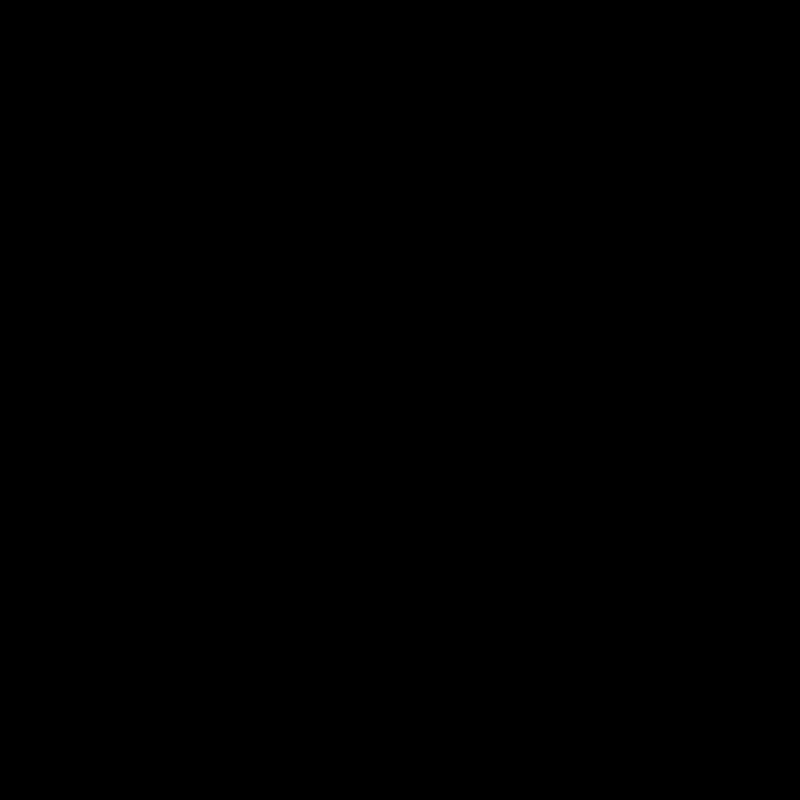

In [ ]:
from IPython.display import display
from PIL import Image

model.eval()
with torch.no_grad():
    # Render NeRF output for the held-out validation pose
    nerf_output = render_image(
        model,
        directions,
        val_pose,
        near,
        far,
        samples_per_ray,
        chunk=validation_chunk,
    ).cpu().numpy()

nerf_image = (np.clip(nerf_output, 0.0, 1.0) * 255).astype(np.uint8)
display(Image.fromarray(nerf_image))
